<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [2]:
# Import libraries.
import json
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis.gensim
import re
import squarify
import spacy

from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline

/Users/ericchiyembekeza/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-eIKOd8Ug/lib/python3.7/site-packages/gensim/corpora/dictionary.py:12: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict
/Users/ericchiyembekeza/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-eIKOd8Ug/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
import pandas as pd

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [4]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [6]:
yelp.shape

(10000, 9)

In [16]:
yelp['text']

0       BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...
1       Came here for lunch Togo. Service was quick. S...
2       I've been to Vegas dozens of times and had nev...
3       We went here on a night where they closed off ...
4       3.5 to 4 stars Not bad for the price, 12.99 fo...
5       Tasty, fast casual Latin street food. The menu...
6       This show is absolutely amazing!! What an incr...
7       Came for the Pho and really enjoyed it! We got...
8       Absolutely the most Unique experience in a nai...
9       Wow. I walked in and sat at the bar for 10 min...
10      We popped in for dinner yesterday with no rese...
11      Thw worst stay ever! So first i ended up payin...
12      Great friendly customer service and quality fo...
13      The food was great! It was super busy but our ...
14      Talk about getting ripped off. They charged us...
15      Girls night out tonight with my kid so we deci...
16      Stopped in here for a few drinks flying out of...
17      This i

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [7]:
def tokenize(doc):
    lemmas = []
    
    doc = nlp(doc)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) \
        and ((token.pos_!= 'PRON') and token.like_num == False):
            lemmas.append(token.lemma_)
    
    return lemmas

In [8]:
def clean(column):
    """
    Removes dollar signs and reduces any excess whitespace to a single
    space per instance.
    """
    column = column.copy()
    
    # Remove dollar signs.
    column = column.str.replace('$', '')
    
    # Reduce any excess whitespace to a single space per instance.
    column = column.str.replace(r'\s+', ' ')
    
    return column

In [10]:
nlp = spacy.load('en_core_web_lg')

In [11]:
#Clean text
yelp['text'] = clean(yelp['text'])

In [12]:
# Generate tokens
tokens = yelp['text'].apply(tokenize)

In [13]:
# View tokens
tokens[0]

['beware',
 'fake',
 'fake',
 'fake',
 'small',
 'business',
 'Los',
 'Alamitos',
 'receive',
 'look',
 'like',
 'legitimate',
 'bill',
 'account',
 'number',
 'call',
 'phone',
 'number',
 'list',
 'wait',
 'time',
 'hold',
 'say',
 'minute',
 'leave',
 'message',
 'live',
 'person',
 'phone',
 'matter',
 'number',
 'select',
 'leave',
 'firm',
 'message',
 'contact',
 'BBB',
 'attorney',
 'company',
 'try',
 'scam',
 'business',
 'illegal']

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [14]:
# Instantiate vectorizer object.
tfidf = TfidfVectorizer(min_df=0.01, 
                        max_df=0.98,
                        ngram_range=(1,2))

# Create a vocabulary and get word counts per document.
dtm = tfidf.fit_transform(tokens.astype(str))

# Get feature names to use as dataframe column headers.
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# Preview feature matrix.
dtm.head()

,30,able,absolutely,actually,add,affordable,afternoon,ago,agree,ahead,...,wrap,write,wrong,year,year ago,yelp,yes,young,yum,yummy
0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.095214,0.0,0.0,0.0,0.146219,0.0,0.0
3,0.0,0.0,0.0,0.25488,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [15]:
# Instantiate nearest neighbors model.
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

# Fit on TF-IDF Vectors
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

Write a fake review and query for the 10 most similiar reviews
Print the text of the reviews. Do you notice any patterns?

In [17]:
# Create a fake negative review.
bad_review = ('I was not a fan of this place at all. It was weird and smelled terrible')

In [18]:
# Vectorize fake review.
bad_vec = tfidf.transform([bad_review])

In [19]:
#10 most similar reviews.
bad_distances, bad_indices = nn.kneighbors(bad_vec.todense(), 10)

In [21]:
yelp.iloc[bad_indices[0]][['stars', 'text']]

,stars,text
6311,5,天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用...
6204,5,旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。 質問にも丁寧に...
9288,1,The place is terrible. the service is terrible...
2627,1,"Terrible terrible terrible went to get a ""hot ..."
2135,1,Terrible airline. They have nothing to offer a...
7656,3,Arrive after 12 Liquor creates weird dancers S...
5298,1,Terrible.. absolutely terrible. Dr. Hinds is e...
5366,1,Don't shop here. The owner John Menard is PURE...
4673,2,Terrible terrible terrible. After they lost my...
372,1,If you're a fan of explosive diarrhea and real...


In [23]:
for text in yelp.iloc[bad_indices[0]]['text']:
    print(f'{text}\n')

天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用心製作，包含擺盤精緻、佐料衛生，夏日想開胃，這是一個不錯的選擇，服務人員也很敬業，以後會常常來

旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。 質問にも丁寧に答えてくれましたし、日本人の方も日本語が話せる方も居て、とても綺麗で居心地のいいお店でした。 ネイルはちはるさんと言う綺麗な方が丁寧にしてくれとても気に入りました。 予定になかったまつ毛エクステもお願いし、日本ではまだあまりないブラウンカラーのエクステをしてもらい、とても気に入りました。 また是非マッサージなどで伺いたいと思います。

The place is terrible. the service is terrible, too. I ordered one cafe and went to another shop, they towed my car. And they wont tell me where my car is unless I gave them my credit card number. I have no choice and called the police. I wont go to this Tim Hortons anymore. The owner is too cheap.

Terrible terrible terrible went to get a "hot and ready pizza and box" which is supposed to be ready between the hours of 4 and 8 p.m. at 7:24 p.m. here it is 8 p.m. and I still have not received my order which I was told would be ready in 12 to 15 minutes this place is terrible terrible terrible and I will no longer be spending my money at this particular little Little Caesars if any L

I notice that some of the words that I used in my review, are also present in many of these reviews.

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [24]:
# Create pipeline components.
vectorizer = TfidfVectorizer()
classifier = KNeighborsClassifier()

In [25]:
# Define the pipeline.
pipe = Pipeline([('vect', vectorizer), 
                 ('clf', classifier)])

In [26]:
# Fit pipeline to data.
pipe.fit(tokens.astype(str), yelp['stars'])

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [27]:
# Use the pipeline to predict a star rating for a fake review.
pipe.predict([bad_review])

array([1])

Tune pipeline.

In [29]:
# Define parameter space for exploration.
parameters = {
    'vect__max_df': (0.95, 0.98),
    'vect__min_df': (0.02, 0.05),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__n_neighbors': (5, 10),
    'clf__weights':('uniform', 'distance')
}

In [30]:
# Search parameter space for best model.
grid_search = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(tokens.astype(str), yelp['stars'])

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  5.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.95, 0.98), 'vect__min_df': (0.02, 0.05), 'vect__max_features': (500, 1000), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__n_neighbors': (5, 10), 'clf__weights': ('uniform', 'distance')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [31]:
#Best score
grid_search.best_score_

0.4761

In [32]:
# Compare to baseline accuracy.
accuracy_score([5]*len(yelp['stars']), yelp['stars'])

0.4462

In [33]:
#Adjust the grid search to improve results
grid_search_mae = GridSearchCV(pipe, 
                               parameters, 
                               scoring='neg_mean_absolute_error', 
                               cv=3, 
                               n_jobs=-1, 
                               verbose=1)
grid_search_mae.fit(tokens.astype(str), yelp['stars'])

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  5.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.95, 0.98), 'vect__min_df': (0.02, 0.05), 'vect__max_features': (500, 1000), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__n_neighbors': (5, 10), 'clf__weights': ('uniform', 'distance')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [34]:
# Get MAE of best model.
abs(grid_search_mae.best_score_)

0.9859

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Keep the `iterations` parameter at or below 5 to reduce run time
    - The `workers` parameter should match the number of physical cores on your machine.
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [35]:
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

Learn the vocubalary of the yelp data:

In [36]:
#Easier for me to create a generator
def doc_stream(filename):
    with open(filename) as f:
        for line in f:
            text = ' '.join(json.loads(line.strip())['text'].split())
            text = text.replace('$', '')
            tokens = tokenize(str(text))
            yield tokens

In [37]:
streaming_data = doc_stream('./data/review_sample.json')

In [38]:
id2word = corpora.Dictionary(doc_stream('./data/review_sample.json'))

In [39]:
id2word.filter_extremes(no_below=5, no_above=0.05)

In [40]:
#filtered dictionary
len(id2word.keys())

6202

Create a bag of words representation of the entire corpus

In [41]:
corpus = [id2word.doc2bow(review) for review in tokens]

Your LDA model should be ready for estimation: 

In [42]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   iterations=5,
                   workers=4,
                   num_topics = 7 # You can change this parameter
                  )

/Users/ericchiyembekeza/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-eIKOd8Ug/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/ericchiyembekeza/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-eIKOd8Ug/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/ericchiyembekeza/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-eIKOd8Ug/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generat

In [43]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:10]) for t in words]

In [44]:
for id, t in enumerate(topics):
    print(f'Topic {id+1}: {t}')
    print("\n")

Topic 1: store car pizza beer owner old rice selection shop actually


Topic 2: store coffee car seat cook line wine stay shop rice


Topic 3: store roll line family stay meat charge car sandwich free


Topic 4: pizza car fast burger usually use old option store job


Topic 5: pizza meat beer store perfect stay item dessert high coffee


Topic 6: burger pizza ok meat option far stay old deal free


Topic 7: sandwich hair coffee live owner have cream line store seat




Create 1-2 visualizations of the results

In [45]:
pyLDAvis.enable_notebook()

In [46]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

/Users/ericchiyembekeza/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-eIKOd8Ug/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.003393 -0.004220       1        1  14.514454
0      0.003032  0.006118       2        1  14.388535
6      0.000909 -0.000056       3        1  14.345818
2      0.005954 -0.004977       4        1  14.314248
4     -0.003010  0.001889       5        1  14.262191
3     -0.004889 -0.000121       6        1  14.140672
1      0.001396  0.001367       7        1  14.034083, topic_info=     Category        Freq        Term       Total  loglift  logprob
129   Default  390.000000        hair  390.000000  30.0000  30.0000
524   Default  808.000000       store  808.000000  29.0000  29.0000
77    Default  347.000000       party  347.000000  28.0000  28.0000
245   Default  750.000000       pizza  750.000000  27.0000  27.0000
315   Default  485.000000          ok  485.000000  26.0000  26.0000
966   Default  556.000000       owner  556.000000  25.0000  25.0000
368   Default  528.000000      family  528.000000  24.0000  24.0000
1243  Default  434.000000        beef  434.000000  23.0000  23.0000
45    Default  461.000000        fast  461.000000  22.0000  22.0000
196   Default  431.000000        wine  431.000000  21.0000  21.0000
170   Default  454.000000         far  454.000000  20.0000  20.0000
27    Default  445.000000       quick  445.000000  19.0000  19.0000
155   Default  649.000000        meat  649.000000  18.0000  18.0000
15    Default  481.000000        live  481.000000  17.0000  17.0000
463   Default  612.000000        beer  612.000000  16.0000  16.0000
412   Default  548.000000     perfect  548.000000  15.0000  15.0000
815   Default  620.000000      coffee  620.000000  14.0000  14.0000
531   Default  685.000000         car  685.000000  13.0000  13.0000
211   Default  453.000000       bread  453.000000  12.0000  12.0000
296   Default  476.000000        have  476.000000  11.0000  11.0000
486   Default  372.000000        will  372.000000  10.0000  10.0000
420   Default  462.000000  atmosphere  462.000000   9.0000   9.0000
182   Default  361.000000        nail  361.000000   8.0000   8.0000
646   Default  559.000000    sandwich  559.000000   7.0000   7.0000
57    Default  552.000000         old  552.000000   6.0000   6.0000
327   Default  534.000000        roll  534.000000   5.0000   5.0000
116   Default  420.000000  absolutely  420.000000   4.0000   4.0000
609   Default  647.000000      burger  647.000000   3.0000   3.0000
371   Default  496.000000         job  496.000000   2.0000   2.0000
493   Default  372.000000        fish  372.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
1681   Topic7   60.001461        turn  328.933777   0.2622  -6.4743
941    Topic7   72.991615     helpful  413.683075   0.2289  -6.2783
26     Topic7   66.452126     parking  373.037994   0.2385  -6.3722
392    Topic7   79.376129       water  463.271484   0.1996  -6.1945
688    Topic7   66.871307      decent  379.843445   0.2267  -6.3659
420    Topic7   78.596313  atmosphere  462.920227   0.1905  -6.2043
634    Topic7   84.019287        huge  501.921112   0.1763  -6.1376
53     Topic7   96.965240        line  606.471069   0.1304  -5.9943
486    Topic7   65.175880        will  372.631805   0.2202  -6.3916
205    Topic7   79.682709    waitress  480.000946   0.1679  -6.1906
190    Topic7   87.896202        shop  542.651794   0.1434  -6.0925
531    Topic7  105.227135         car  685.861877   0.0891  -5.9125
352    Topic7   75.660011      change  450.812500   0.1789  -6.2424
1650   Topic7   73.353508       house  433.546753   0.1870  -6.2734
6      Topic7   83.403786    business  517.764343   0.1379  -6.1450
152    Topic7   82.329781        busy  521.194153   0.1183  -6.1579
142    Topic7   69.113335        talk  406.488647   0.1919  -6.3329
65     Topic7   92.944267        stay  650.571899   0.0178  -6.0367
412    Topic7   82.639702     perfect  548.360962   0.0712  -6.1542
627

In [47]:
# Define weightings for top ten words in each topic.
weights = [[float(f) for f in re.findall(r'([\d.]{5})', topic[1])] \
           for topic in lda.print_topics()]

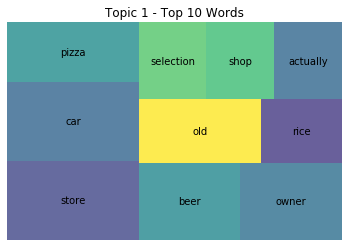

In [48]:
squarify.plot(sizes=weights[0], label=words[0], alpha=0.8)
plt.axis('off')
plt.title('Topic 1 - Top 10 Words')
plt.show()

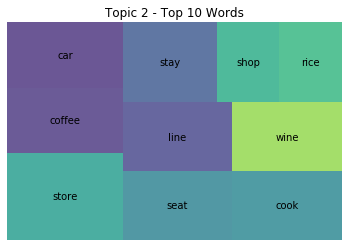

In [50]:
squarify.plot(sizes=weights[2], label=words[1], alpha=0.8)
plt.axis('off')
plt.title('Topic 2 - Top 10 Words')
plt.show()

Based on the intertopic model, there is virtually no overlap. There is quite a bit of distinction between the topics.
It is also pretty difficult to discern whether certain topics have more positive or negative reviews. 

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)